In [1]:
import pandas as pd
import dask.dataframe as dd
import dask.array as da

import seaborn as sns
import matplotlib.pyplot as plt

from dask.distributed import Client

client = Client(n_workers=4)

# Investigating the Potential of ML in Detecting Attractive Investments from Result and Balance Sheet Data

* Previous research available on how machine learning can be applied to find attractive investment 
* However, these are built on restricted data 
* Hence, it would be beneficial to  explore the potential of an ML model only based on easily accessible data, e.g. financial figures from result and balance sheet data 
* Sweden is a good case study as companies are obliged to report financial figures 

## Research question: Can an ML model only trained on result and balance sheet data, be valuable to determine attractive investments?

* Hypothesis: Even tough other information and soft variables usually also goes into a investment decision, it can still help an investment decision

# Models are currently running, some features are dominating drivers to an investment, the nr. of new companies and share premium equity is flattening out over the latter 5 years in the data set 

* Initial observations on the serrano data set (known to be the most comprehensive available data set on the Swedish market): c. 13 % missing entries on share premium reserve 
* By removing this 13%, most other missing feature values followed
* Some c. 30 more interesting features have been selected out of the 128 features 
* The data set have been worked through with data imputation and some feature engineering - 'CAGR net sales and profit' and 'age of a company'
* Odd results in the year over year analysis that shows the nr. of new companies and the total amount of share premium reserve is flattening out over the latter 5 years, 2012-17', in the data set - needs to be investigated and the data set might need to splitted differently  
* Feature importance analysis shows that there are some dominating factors for investments - interesting analysis for the report 
* Due to up shown collinearity, further feature selection have been possible 
* Some ML models have been selected and are currently running - LONG lead time 
* Next steps: Validate current results, add neural network, run and evaluate the built models

# Year over year analysis shows that the nr. of new companies and the total amount of share premium reserve is flattening out over the latter 5 years, 2012-17', in the data set

In [2]:
df_no_missing = dd.read_csv("data/noOverkursMissing_listversion.csv", assume_missing=True)

* Number of entries per year

In [3]:
def datapoints_per_year(df):
    return df.groupby('ser_year').ser_year.count().compute()

In [55]:
# nr datapoints per year

num_datapoints_per_year = datapoints_per_year(df_no_missing)
#num_datapoints_per_year.rename(columns = {'ser_year':'year', '':'nr of companies'}, inplace = True)

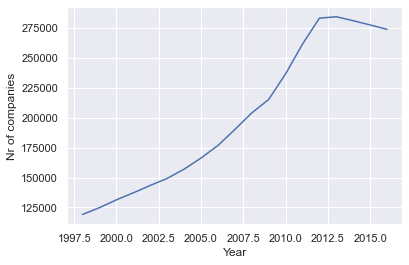

In [57]:
ax = sns.lineplot(data=num_datapoints_per_year)
ax.set(xlabel='Year', ylabel='Nr of companies')
plt.show()

* Number of new companies per year

In [6]:
# nr of new companies per year

def newcompanies_per_year(df):
    return df[df['ser_nystartat'] == 1].groupby('ser_year').ser_year.count().compute()

In [7]:
num_newcompanies_per_year = newcompanies_per_year(df_no_missing)

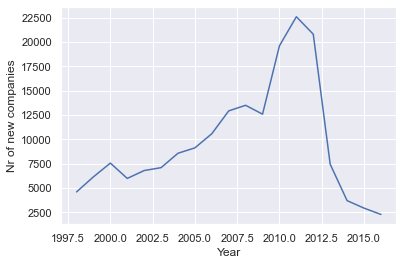

In [58]:
ax = sns.lineplot(data=num_newcompanies_per_year)
ax.set(xlabel='Year', ylabel='Nr of new companies')
plt.show()

* Total share premium reserve over years

In [9]:
# total overkurs per year

def totaloverkurs_per_year(df):
    return df[['br10b_overkurs', 'ser_year']].groupby('ser_year').ser_year.sum().compute()

In [10]:
totaloverkurs_per_year = totaloverkurs_per_year(df_no_missing)

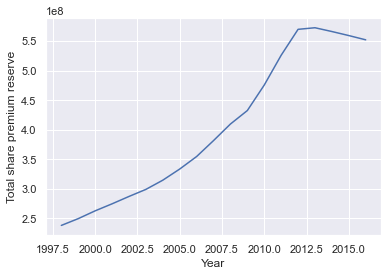

In [60]:
ax = sns.lineplot(data=totaloverkurs_per_year)
ax.set(xlabel='Year', ylabel='Total share premium reserve')
plt.show()

# Machine learning model building and feature importance

In [12]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da

import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


Automatically created module for IPython interactive environment


In [22]:
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
X_train = pd.read_csv('data/X_train_normalized_oh.csv')
X_val = pd.read_csv('data/X_val_normalized_oh.csv')
X_test = pd.read_csv('data/X_test_normalized_oh.csv')
y_train = pd.read_csv('data/y_train.csv')
y_val = pd.read_csv('data/y_val.csv')
y_test = pd.read_csv('data/y_test.csv')

In [24]:
X_train.rename(columns = {'CAGR': 'CAGR net sales', 
                          'CAGR_profit': 'CAGR profit',
                          'br01_imanlsu': 'Intangible fixed assets' , 
                          'br02_matanlsu': 'Tangible fixed assets', 
                          'br04_fianltsu':'Financial assets',
                          'br05_anltsu':'Total fixed assets', 
                          'br06_lagerkford':'Inventories', 
                          'br06g_kfordsu':'Total current receivables', 
                          'br08_omstgsu':'Total current assets', 
                          'br09_tillgsu': 'Total assets', 
                          'br10_eksu': 'Total equity', 
                          'br10a_aktiekap': 'Share capital', 
                          'br10e_balres':'Accumulated profit or loss',
                          'br10h_resarb':'Profit/loss for the year', 
                          'br13_ksksu':'Total current liabilities', 
                          'br15_lsksu':'Total non-current liabilities',
                          'br17_eksksu':'Total equity and liabilities',
                          'bslov_antanst':'Employees',
                          'rr01_ntoms':'Net sales',
                          'rr02b_aktarb': 'Capitalized work',
                          'rr04_perskos':'Personnel expenses',
                          'rr04c_foradlv':'Value added',
                          'rr06_rorkoov':'Orther operating expenses',
                          'rr06a_prodkos':'Production costs',
                          'rr07_rorresul':'Operating profit/loss',
                          'rr09_finkostn':'Financial expenses',
                          'rr10_finres_int':'Internal financial performance', 
                          'rr11_finres_ext':'External financial performance',
                          'rr14_skatter':'Taxes',
                          'rr15_resar': 'Net profit/loss for the year',
                          'ser_nyregistrerat':'Registered during the year ',
                          'ser_nystartat': 'Indicator, newly started',
                          'ser_year': 'Year',
                          'years_in_dataset_at_time_t': 'Age of company',
                          'bransch_borsbransch_konv_40.0': 'Bransch sector 40',
                          'bransch_borsbransch_konv_20.0': 'Bransch sector 20',
                          'bransch_borsbransch_konv_30.0': 'Bransch sector 30',
                          'bransch_borsbransch_konv_25.0': 'Bransch sector 25',
                          'bransch_borsbransch_konv_60.0': 'Bransch sector 60',
                          'bransch_borsbransch_konv_50.0': 'Bransch sector 50',
                          'bransch_borsbransch_konv_22.0': 'Bransch sector 22',
                          'bransch_borsbransch_konv_98.0': 'Bransch sector 98',
                          'bransch_borsbransch_konv_45.0': 'Bransch sector 45',
                          'bransch_borsbransch_konv_10.0': 'Bransch sector 10',
                          'bransch_borsbransch_konv_15.0': 'Bransch sector 15',
                          'bransch_borsbransch_konv_99.0': 'Bransch sector 99',
                          'bransch_borsbransch_konv_35.0': 'Bransch sector 35'
                           }, inplace = True)

# Feature importance analysis

In [25]:
# selected from hiearchy cluster and business judgement

topmost_important_features = ['CAGR net sales', 
                              'CAGR profit', 
                              'Intangible fixed assets',
                              'Tangible fixed assets', 
                              'Financial assets',
                              'Total fixed assets',
                              'Inventories', 
                              'Total current assets',
                              'Total assets',
                              'Share capital',
                              'Accumulated profit or loss',
                              'Profit/loss for the year',
                              'Total non-current liabilities',
                              'Employees', 
                              'Net sales',
                              'Capitalized work', 
                              'Personnel expenses',
                              'Production costs',
                              'Operating profit/loss', 
                              'Financial expenses',
                              'Internal financial performance', 
                              'External financial performance',
                              'Taxes', 
                              'Net profit/loss for the year',
                              'Registered during the year ',
                              'Year', 'Age of company',
                              'Bransch sector 40', 
                              'Bransch sector 20', 
                              'Bransch sector 30',
                              'Bransch sector 25', 
                              'Bransch sector 60', 
                              'Bransch sector 50', 
                              'Bransch sector 22',
                              'Bransch sector 98',
                              'Bransch sector 45',
                              'Bransch sector 10',
                              'Bransch sector 15', 
                              'Bransch sector 99',
                              'Bransch sector 35'
                             ]



X_train_v01 = X_train[topmost_important_features]

In [26]:
X_train_v01.columns

Index(['CAGR net sales', 'CAGR profit', 'Intangible fixed assets',
       'Tangible fixed assets', 'Financial assets', 'Total fixed assets',
       'Inventories', 'Total current assets', 'Total assets', 'Share capital',
       'Accumulated profit or loss', 'Profit/loss for the year',
       'Total non-current liabilities', 'Employees', 'Net sales',
       'Capitalized work', 'Personnel expenses', 'Production costs',
       'Operating profit/loss', 'Financial expenses',
       'Internal financial performance', 'External financial performance',
       'Taxes', 'Net profit/loss for the year', 'Registered during the year ',
       'Year', 'Age of company', 'Bransch sector 40', 'Bransch sector 20',
       'Bransch sector 30', 'Bransch sector 25', 'Bransch sector 60',
       'Bransch sector 50', 'Bransch sector 22', 'Bransch sector 98',
       'Bransch sector 45', 'Bransch sector 10', 'Bransch sector 15',
       'Bransch sector 99', 'Bransch sector 35'],
      dtype='object')

## Decision Tree Model

In [27]:
#rf_v01 = RandomForestClassifier(n_estimators=10).fit(X_train_v01, y_train.values.ravel())

In [30]:
dt = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth=10, min_samples_split=8).fit(X_train_v01, y_train.values.ravel())

## Permutation importance

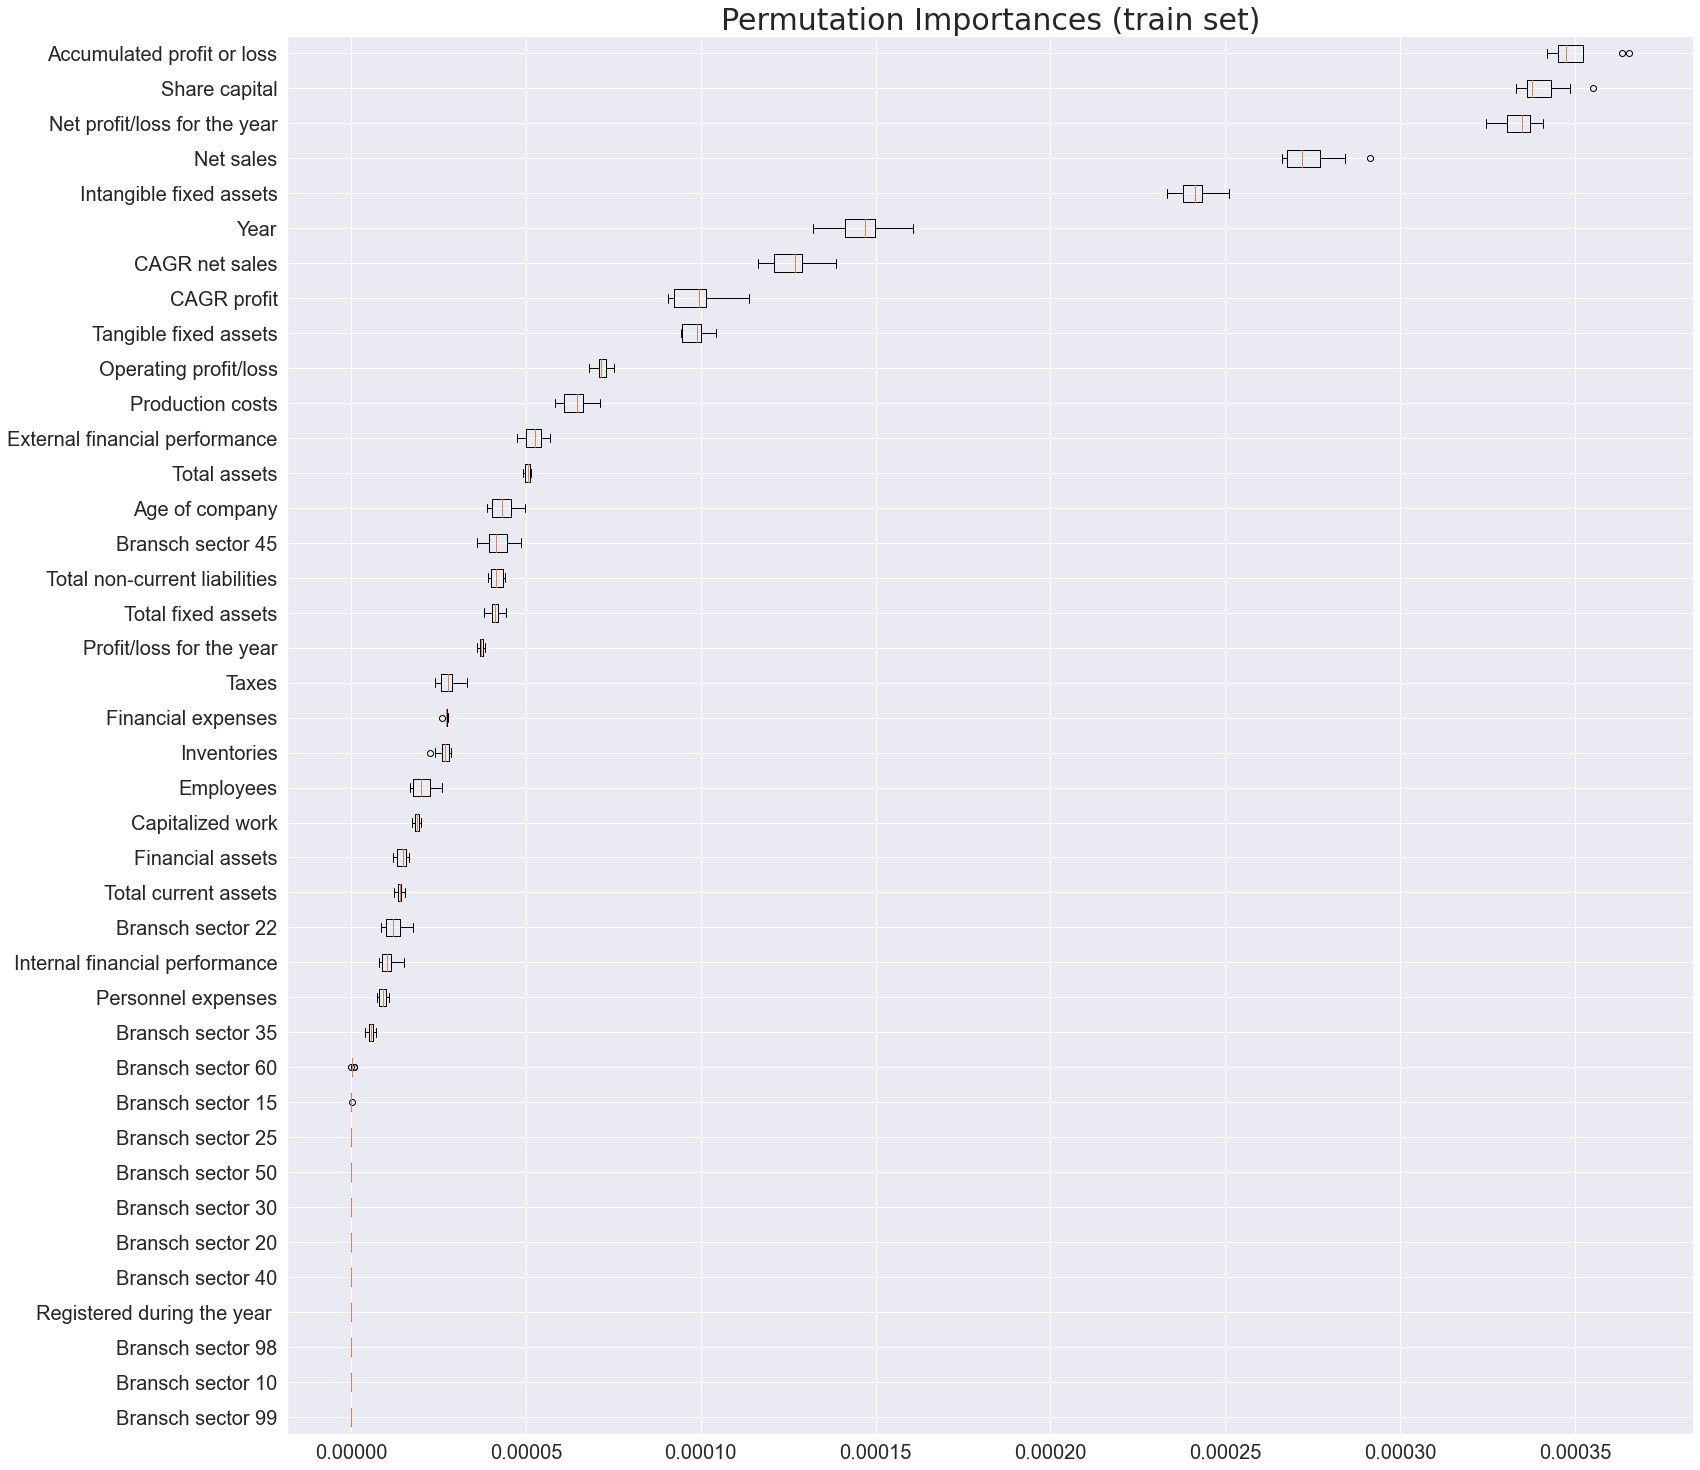

In [105]:
# get the permutation_importance of classifier
result = permutation_importance(dt, X_train_v01, y_train, n_repeats=10,
                                random_state=42, n_jobs=-2)
# sort on importance
sorted_idx = result.importances_mean.argsort()

# plot
fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_v01.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)", fontsize=30)
fig.tight_layout()

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)

plt.show()

## Decision tree feature importance 

<ipython-input-106-cb020839d598>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


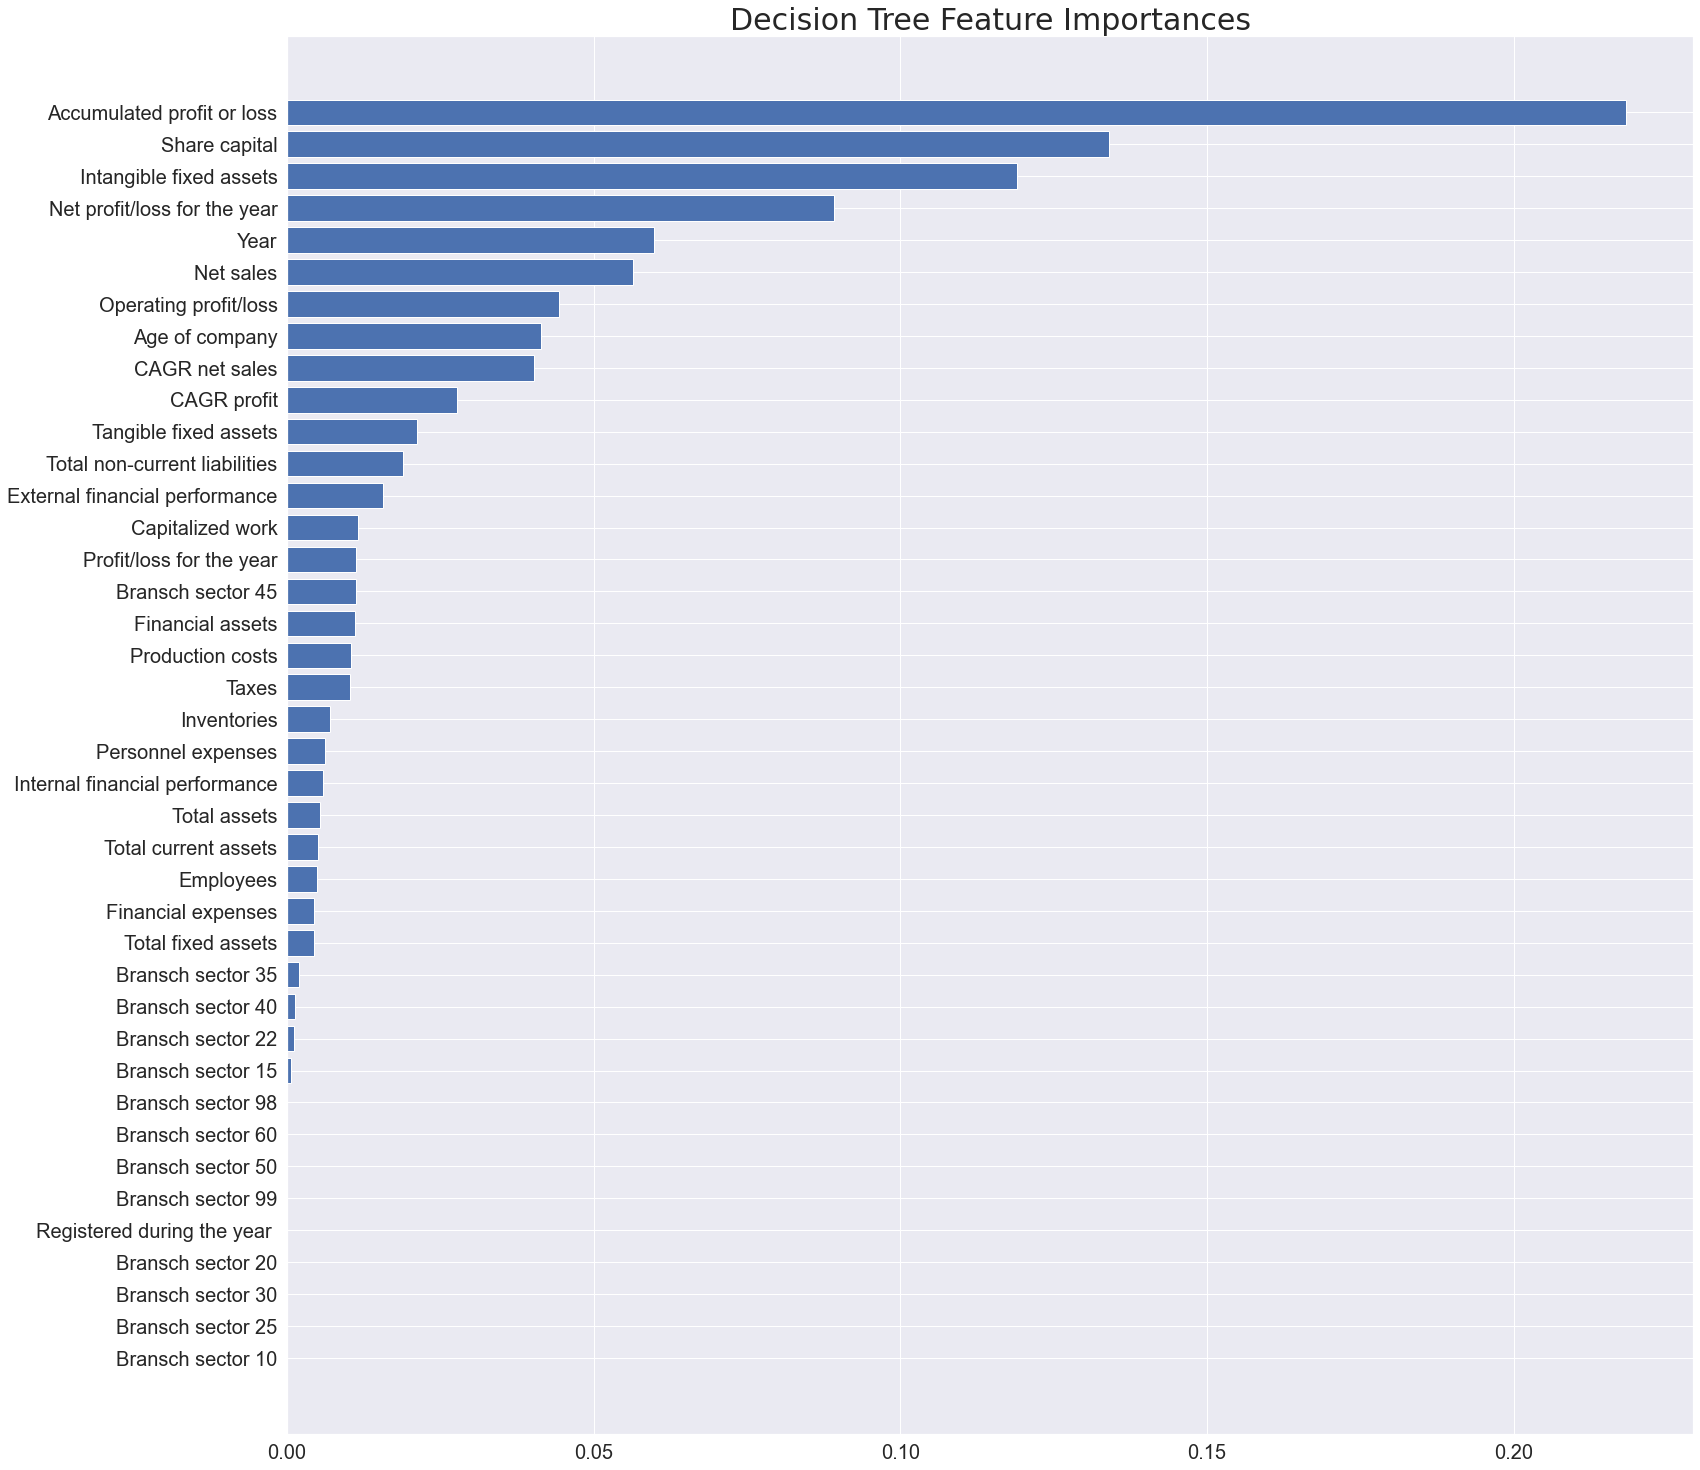

In [106]:
# get feauture names
feature_names = X_train_v01.columns

# get feauture importance
tree_feature_importances = dt.feature_importances_

# sort with respect to feature importance 
sorted_idx = tree_feature_importances.argsort()

# plotting
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Decision Tree Feature Importances", fontsize=30)
fig.tight_layout()

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)

plt.show()

# Handling Multicollinear Features

In [33]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

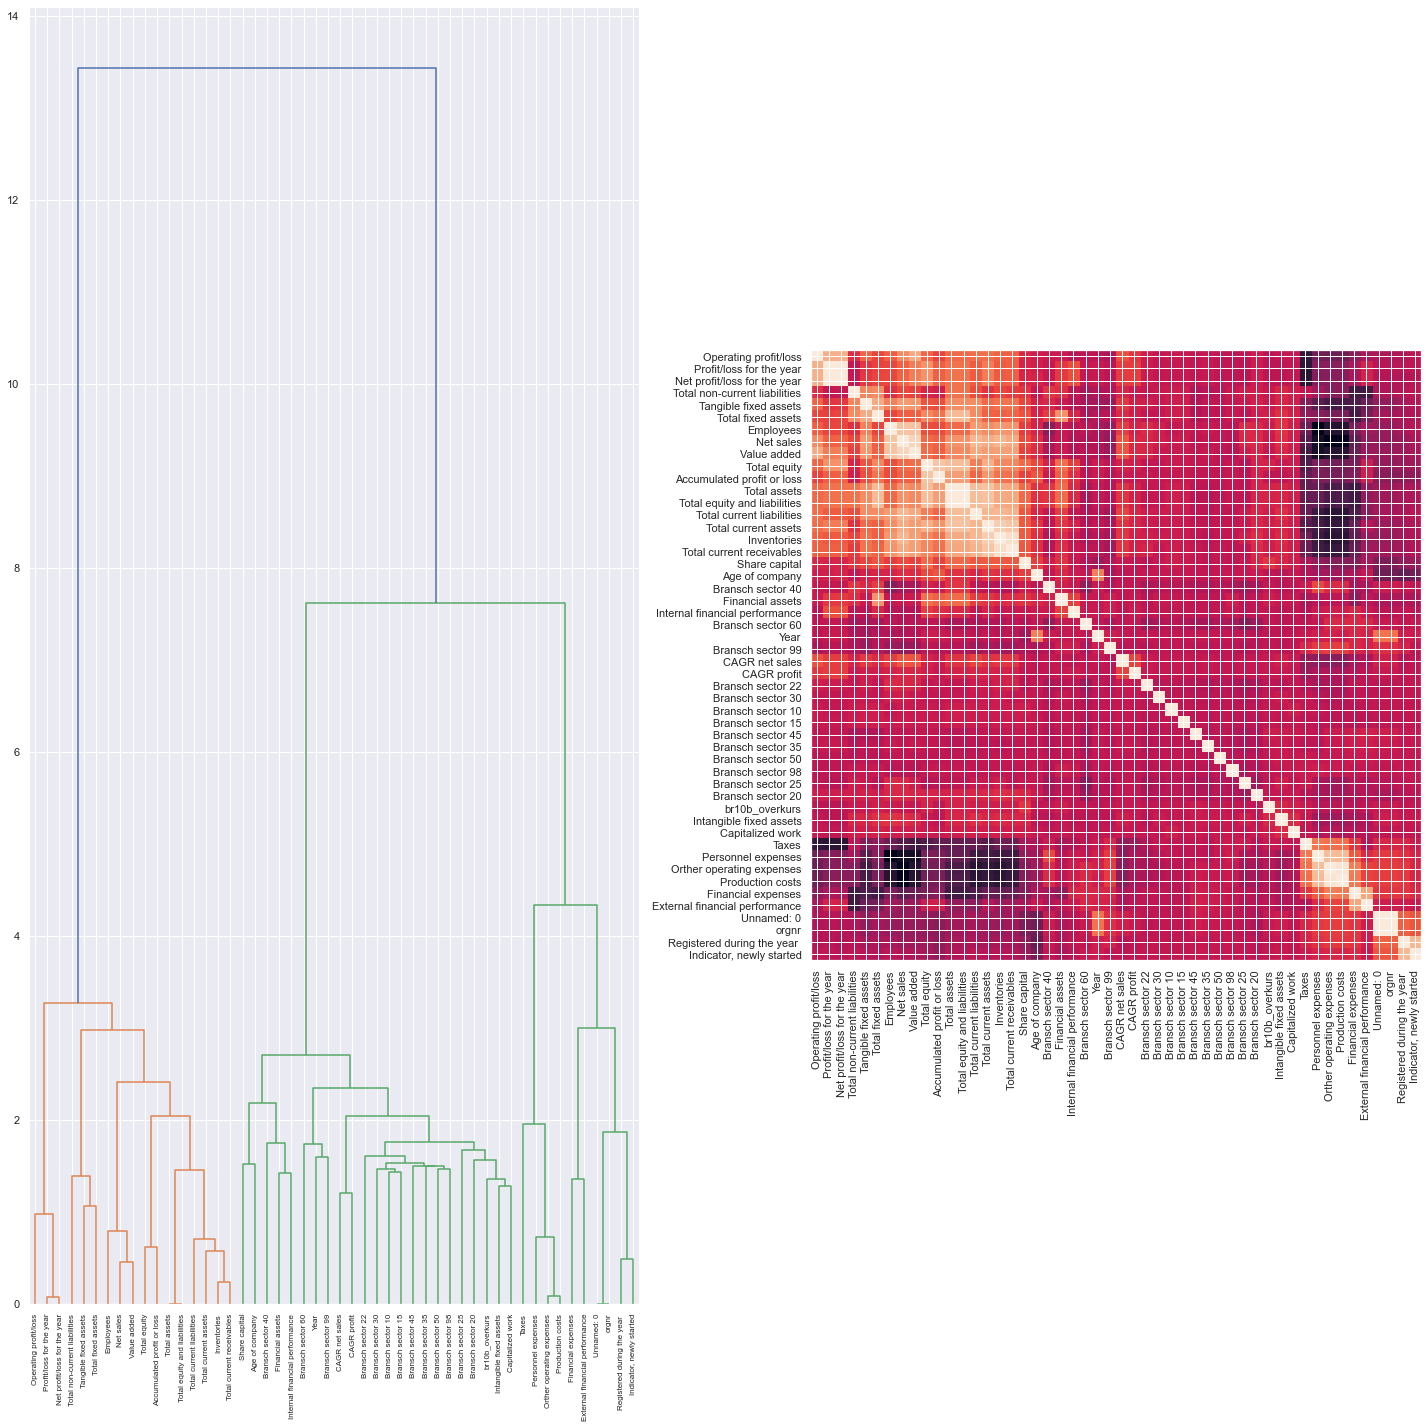

In [34]:
# Hierarchical cluster and correlation matrix


feature_names = X_train.columns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

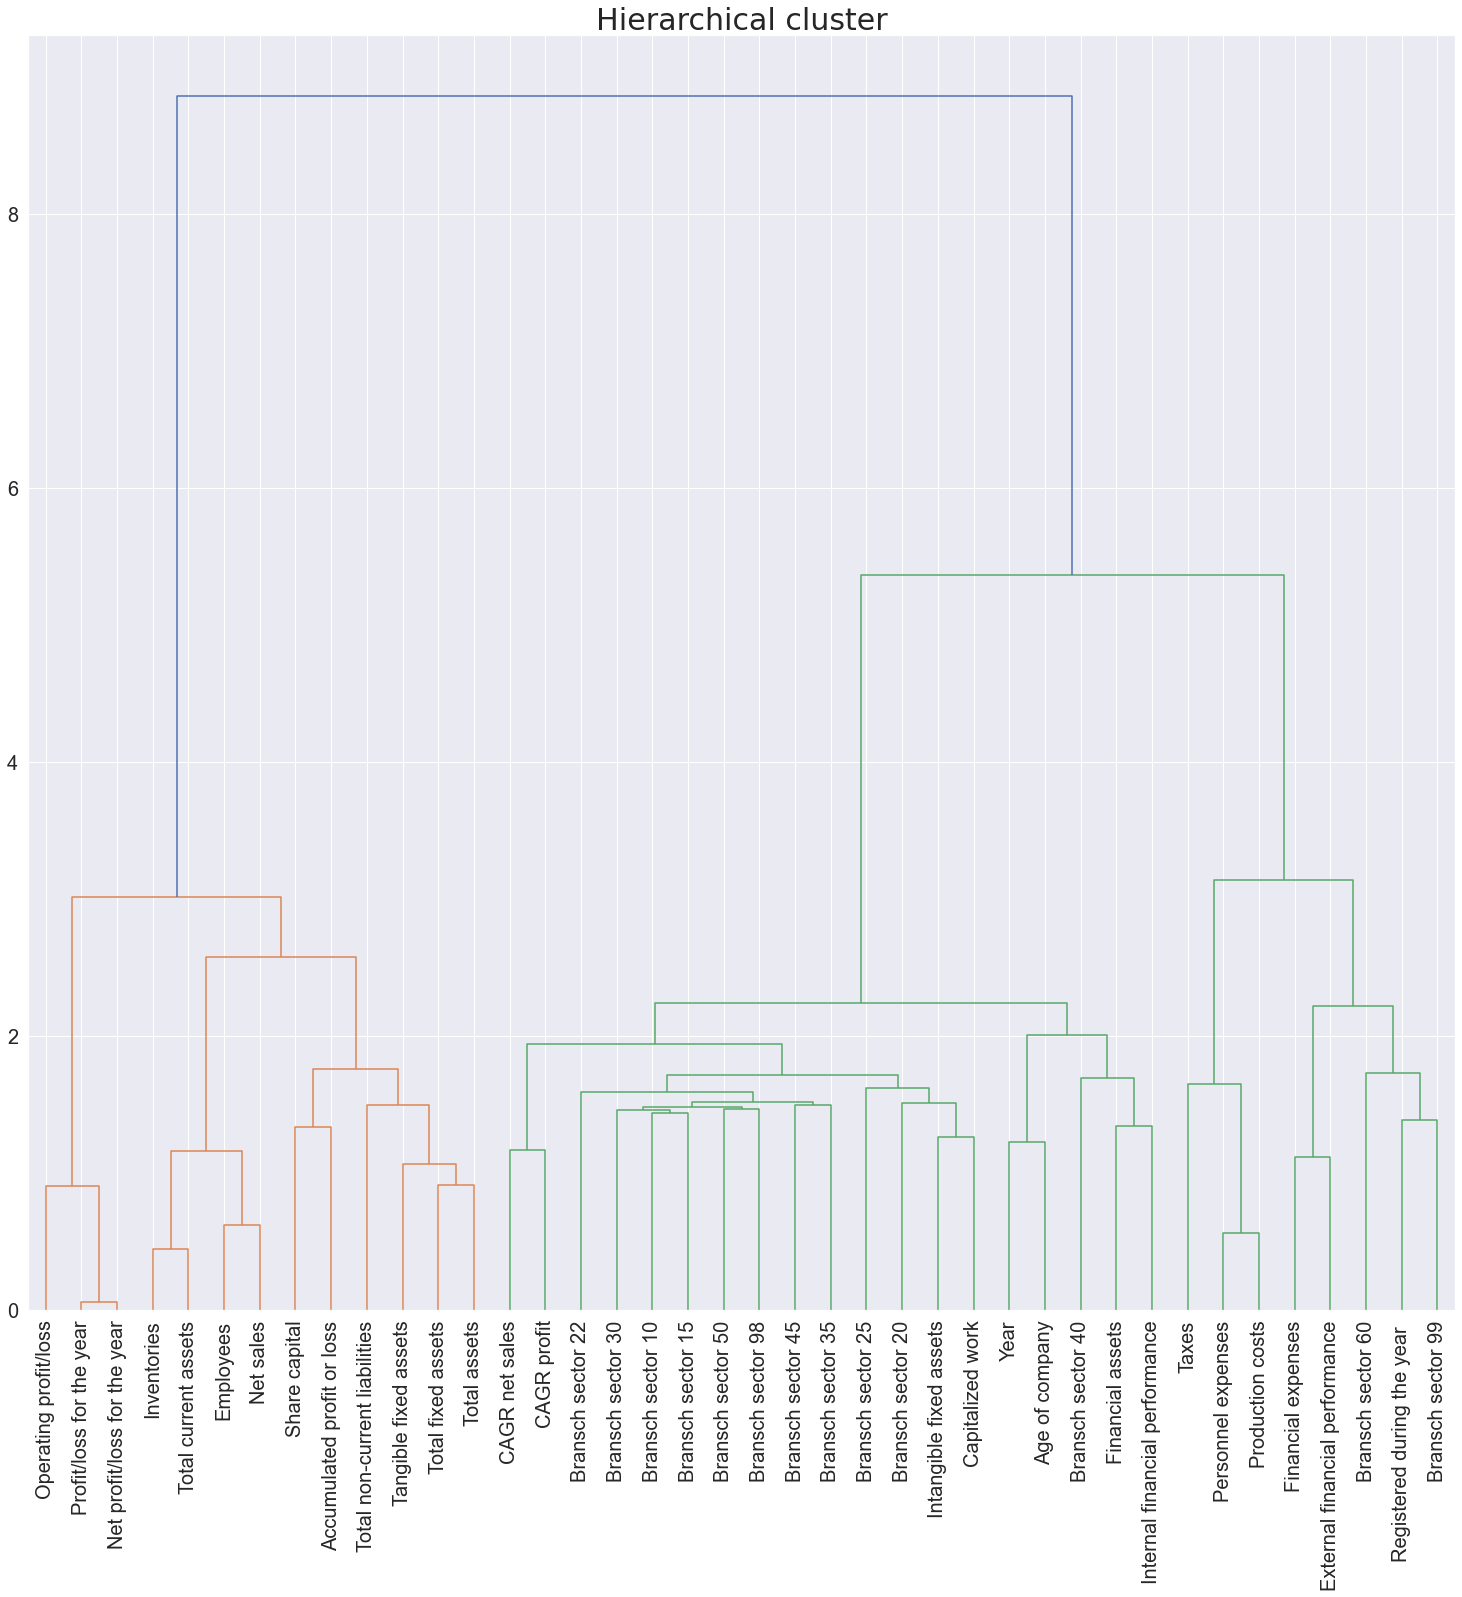

In [101]:
# Only showing hierarchical cluster

feature_names = X_train_v01.columns

fig, ax1 = plt.subplots(figsize=(20, 20))
corr = spearmanr(X_train_v01).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
ax1.set_title("Hierarchical cluster", fontsize=30)
fig.tight_layout()

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)

plt.show()

# Model building

## Machine learning models to test

In [36]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier


models_name = ["Nearest Neighbour Classifier", 
              "Gaussian Naive Bayes Classifier",
              "Decision Tree Classifier",
              "AdaBoost Classifier",
              "Gradient Boosting Classifier",
              "Random Forest Classifier",
              "Support Vector Classifier"]

models_list = [
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    SVC()]

## Hyperparameter tuning - long lead time... currently running in another notebook

In [37]:
from sklearn.model_selection import RandomizedSearchCV
# Can use later to substitute hardcode lists of integer, np.randint is also an option
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

testparams_KNN = dict(n_neighbors=[1, 3, 5, 8, 10], weights=['uniform', 'distance'],
                     p=[1, 2], algorithm = ['auto', 'ball_tree', 'kd_tree'])

testparams_GNB = dict() # no hyperparameter tuning will be applied 

testparams_DTC = dict(criterion = ["gini", "entropy"], splitter = ["best", "random"], 
                      max_depth=np.random.randint(low=4, high=16, size = 3), min_samples_split=np.random.randint(low=2, high=12, size = 5))

testparams_Ada = dict(n_estimators=np.random.randint(low=25, high=1000, size = 5), learning_rate=uniform(loc=0.01, scale=0.99))

testparams_GBC = dict(loss = ['deviance’, ‘exponential'], learning_rate=uniform(loc=0.01, scale=0.99), 
                      n_estimators=np.random.randint(low=50, high=500, size = 5), criterion=['friedman_mse', 'mae'],
                         min_samples_split=np.random.randint(low=2, high=10, size = 5))

testparams_RFC = dict(max_depth=np.random.randint(low=4, high=16, size = 3), n_estimators=np.random.randint(low=25, high=1000, size = 5),
                         criterion = ["gini", "entropy"], max_features = ["sqrt", "log2"], 
                              min_samples_split=np.random.randint(low=2, high=12, size = 5))

testparams_SVC = dict(kernel=['rbf', 'linear', 'poly'], C=uniform(loc=0.5, scale=4.5),
                     gamma = ['scale', 'auto'])

# Put parameters in dictionary
test_params_all = [testparams_KNN, 
                   testparams_GNB, 
                   testparams_DTC, 
                   testparams_Ada, 
                   testparams_GBC,  
                   testparams_RFC,
                   testparams_SVC]

## Next steps: Validate current results, add neural network, run and evaluate the built models

* Validate results
* Add neural network
* Run models and evaluate performance